<h1><center>
    DSOR 646 - Reinforcement Learning </br>
    Brandon Hosley
</center></h1>

In [1]:
import numpy as np
import pandas as pd
import time
%rm -r __pycache__/     # Clear cached python (in case external script updates)
from mcc import MCC     # Local Python script
from hw3_support_functions import parallel_lhs, plot_results, anova, plot_param_comparison

NUM_EPISODES = int(0.5e3)
REPLICATIONS = 10     # At least 10 reps per run
NUM_RUNS = 40


# On-policy Monte Carlo Control (every-visit):

First we will run a Latin Hypercube sampling experiment for hyperparameters.

In [ ]:
def on_policy_experiment(run_index:int, factors:np.ndarray) -> tuple[int,float,float,float]:
    run_start_time = time.time()
    pol = MCC(factors[0],factors[1],factors[2])
    pol.train_on_policy(NUM_EPISODES ,REPLICATIONS)
    maxETDR, maxETDRhw, meanMaxTestEETDR, maxTestHW, meanAULC, hwAULC, secs_taken = pol.get_results()
    alg_score = 0.6*(meanMaxTestEETDR-maxTestHW) + 0.4*(meanAULC-hwAULC)
    print(f"Complete experiment run {run_index} with a score of {alg_score:.2f} ({time.time() - run_start_time:.1f}s)")
    return run_index, maxETDR, maxETDRhw, meanMaxTestEETDR, maxTestHW, meanAULC, hwAULC, secs_taken

factor_table,results_table = parallel_lhs(on_policy_experiment, num_runs=NUM_RUNS)

Next, we can plot the same type of scatter as lesson 9.

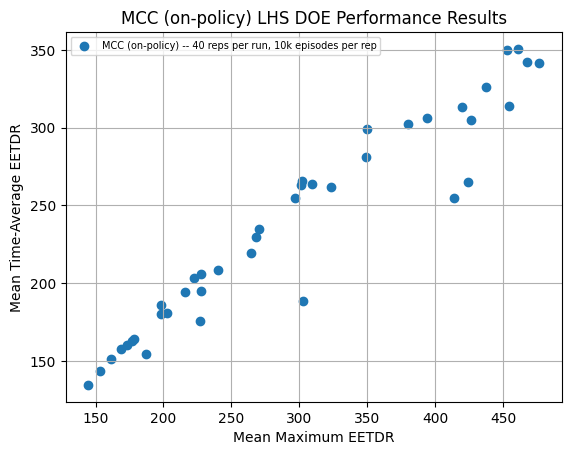

In [16]:
plot_results(results_table)

The next plot is a superficial look at each of the hyperparameter values plotted against the score acheived during the experiments using those parameters.

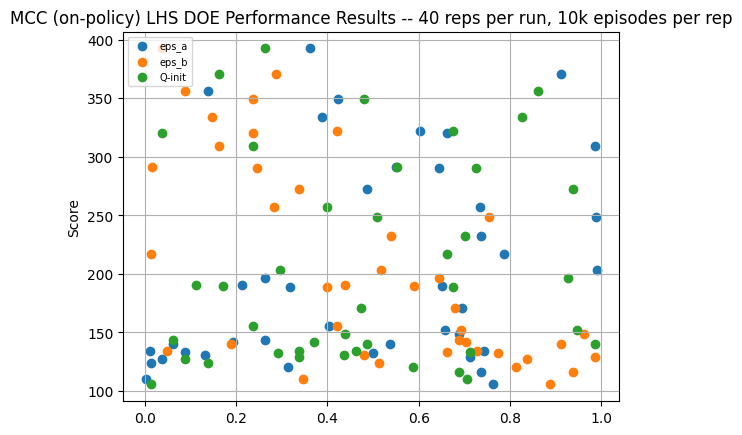

In [18]:
  plot_param_comparison(results_table)

With no clear patterns we can look toward an anova table.

In [7]:
anova(factor_table,results_table)




                            OLS Regression Results                            
Dep. Variable:               AlgScore   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     8.840
Date:                Fri, 10 May 2024   Prob (F-statistic):           2.36e-06
Time:                        02:53:54   Log-Likelihood:                -211.51
No. Observations:                  40   AIC:                             443.0
Df Residuals:                      30   BIC:                             459.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -383.9902     79.275  

The values shown in the ANOVA table provide a hint to a pattern that was not immediately obvious on first pass of the rpevious scatter plot. While there may not be a strong correlation with initial $Q$ or $\varepsilon_a$, all of the top performing models have an $\varepsilon_b$ below $0.5$.

Next, we examine the superlative policy, as measured by the lower bound of its 95% confidence interval for EETDR.


MCC (on-policy)(eps_a=0.32,eps_b=0.40,q0=0.6745511484124121) rep 0...
   Test... Episode:    0, EETDR CI:  13.30 +/- 2.68 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:   25, EETDR CI: 110.43 +/- 17.45 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:   50, EETDR CI: 229.17 +/- 37.32 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:   75, EETDR CI: 309.47 +/- 40.68 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:  100, EETDR CI: 471.50 +/- 26.95 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:  125, EETDR CI: 415.00 +/- 39.06 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:  150, EETDR CI: 450.13 +/- 29.91 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:  175, EETDR CI: 464.03 +/- 31.63 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:  200, EETDR CI: 464.73 +/- 23.69 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:  225, EETDR CI: 436.50 +/- 36.17 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode: 

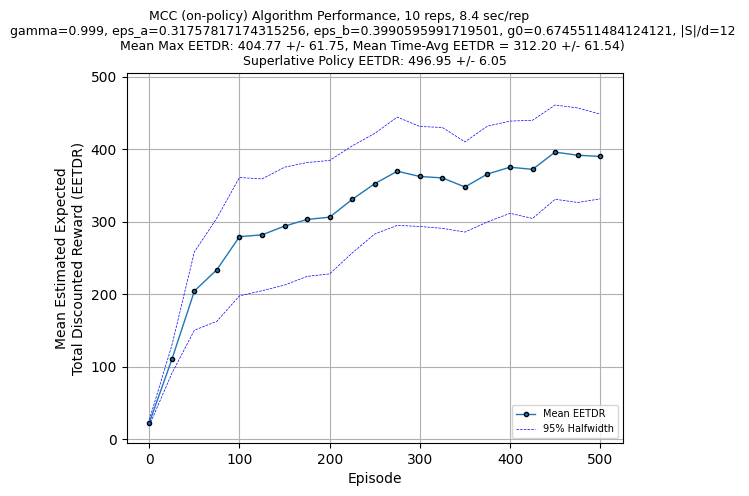

In [9]:
#super_index = np.argmax(results_table[:,-1])
super_index = np.argmax(results_table[1:,6]) - np.argmax(results_table[1:,7]) # 95CILB calculated
superlative_on_policy = MCC(*np.array(results_table[super_index,1:4],float))
superlative_on_policy.train_on_policy(num_episodes=int(0.5e3),replications=10)
superlative_on_policy.show_results()


The learning curve for the superlative policy is displayed above. Conveniently the function also prints the parameters in title. From the first series of experiments the one with $\varepsilon_a=0.644$, $\varepsilon_b=0.245$, $Q_0=0.725$ had the highest CI lower bound, a follow-up round; $0.3176,0.399,0.675$ respectively. Finally, we wish to check the algorithm's execution time. The earlier policy took an average of $7.2$ (the latter $8.4$) secs to execute. The next and final cell in this section we check the average across all reps and experiments performed in this section.

In [12]:
print(np.array(results_table[1:,-2],float).mean())

6.06468195756519


Thus we see that the both superlatives took longer than the average of $6.064$ seconds to execute. We will reexamine this time in the last section, comparing on- and off-policy.

# Off-policy Monte Carlo Control (every-visit, weighted importance sampling):

Next, we will do a similar analysis using the off-policy MCCC

In [ ]:
def off_policy_experiment(run_index:int, factors:np.ndarray) -> tuple[int,float,float,float]:
    run_start_time = time.time()
    pol = MCC(factors[0],factors[1],factors[2])
    pol.train_off_policy(NUM_EPISODES ,REPLICATIONS)
    maxETDR, maxETDRhw, meanMaxTestEETDR, maxTestHW, meanAULC, hwAULC, secs_taken = pol.get_results()
    alg_score = 0.6*(meanMaxTestEETDR-maxTestHW) + 0.4*(meanAULC-hwAULC)
    print(f"Complete experiment run {run_index} with a score of {alg_score:.2f} ({time.time() - run_start_time:.1f}s)")
    return run_index, maxETDR, maxETDRhw, meanMaxTestEETDR, maxTestHW, meanAULC, hwAULC, secs_taken

factor_table,results_table = parallel_lhs(off_policy_experiment, num_runs=NUM_RUNS, on_or_off='off')

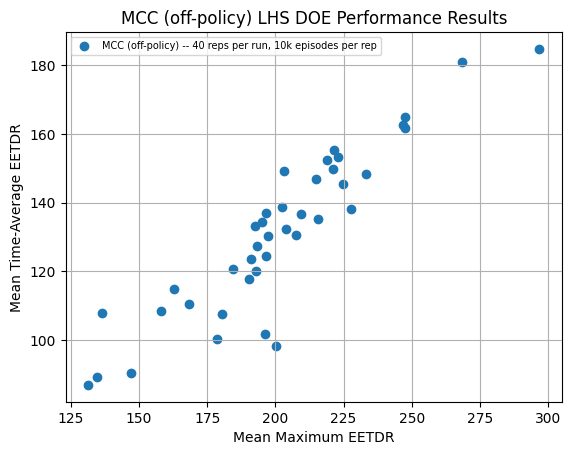

In [20]:
plot_results(results_table, on_or_off='off')

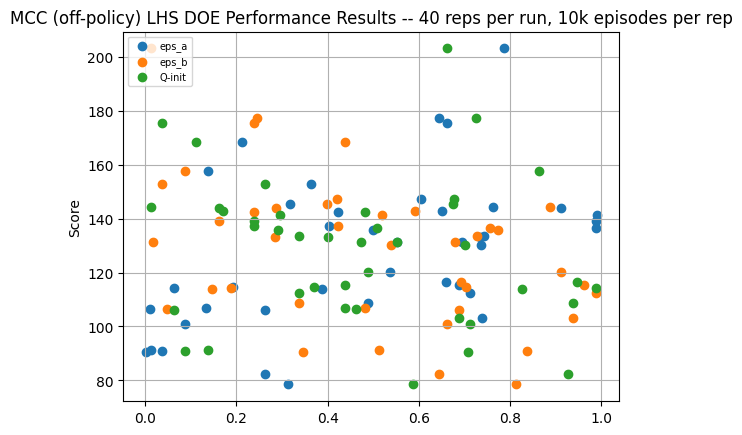

In [21]:
plot_param_comparison(results_table, on_or_off='off')

This scatter plot does not suggest the same pattern that we could see in the on-policy section. It does appear that there may be a small positive correlation between the average score and $\varepsilon_a$. An ANOVA table may provide more definitive answers.

In [22]:
anova(factor_table,results_table)




                            OLS Regression Results                            
Dep. Variable:               AlgScore   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     1.634
Date:                Fri, 10 May 2024   Prob (F-statistic):              0.150
Time:                        03:16:10   Log-Likelihood:                -212.57
No. Observations:                  40   AIC:                             445.1
Df Residuals:                      30   BIC:                             462.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -244.8088     81.404  


MCC (off-policy)(eps_a=0.13,eps_b=0.48,q0=0.4371201428287236) rep 0...
   Test... Episode:    0, EETDR CI:  14.57 +/- 2.31 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:   25, EETDR CI: 110.73 +/- 18.58 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:   50, EETDR CI: 113.10 +/- 13.36 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:   75, EETDR CI: 130.47 +/- 16.89 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:  100, EETDR CI: 132.80 +/- 18.60 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:  125, EETDR CI: 119.50 +/- 12.88 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:  150, EETDR CI: 109.57 +/- 8.75 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:  175, EETDR CI: 122.60 +/- 9.60 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:  200, EETDR CI: 107.07 +/- 8.86 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:  225, EETDR CI: 128.37 +/- 14.32 New Top 10 EETDR 95CILB -- Q recorded
   Test... Episode:  2

/home/hw3/mcc.py:357: RuntimeWarning: invalid value encountered in scalar divide
  Q[sa] += (W / C[sa]) * (Gm - Q[sa]) # update Q-table via weighted incremental update mechanism


   Test... Episode:   25, EETDR CI:  26.70 +/- 7.97
 *------* Current Top 5 Reliable EETDRs: 124.17, 124.10, 124.10, 132.80, 128.37
   Test... Episode:   50, EETDR CI:  70.03 +/- 11.65
 *------* Current Top 5 Reliable EETDRs: 124.17, 124.10, 124.10, 132.80, 128.37
   Test... Episode:   75, EETDR CI:  83.33 +/- 14.25
 *------* Current Top 5 Reliable EETDRs: 124.17, 124.10, 124.10, 132.80, 128.37
   Test... Episode:  100, EETDR CI:  66.77 +/- 5.95
 *------* Current Top 5 Reliable EETDRs: 124.17, 124.10, 124.10, 132.80, 128.37
   Test... Episode:  125, EETDR CI:  69.57 +/- 5.59
 *------* Current Top 5 Reliable EETDRs: 124.17, 124.10, 124.10, 132.80, 128.37
   Test... Episode:  150, EETDR CI:  69.57 +/- 5.59
 *------* Current Top 5 Reliable EETDRs: 124.17, 124.10, 124.10, 132.80, 128.37
   Test... Episode:  175, EETDR CI:  69.47 +/- 5.51
 *------* Current Top 5 Reliable EETDRs: 124.17, 124.10, 124.10, 132.80, 128.37
   Test... Episode:  200, EETDR CI:  71.27 +/- 5.63
 *------* Current Top 

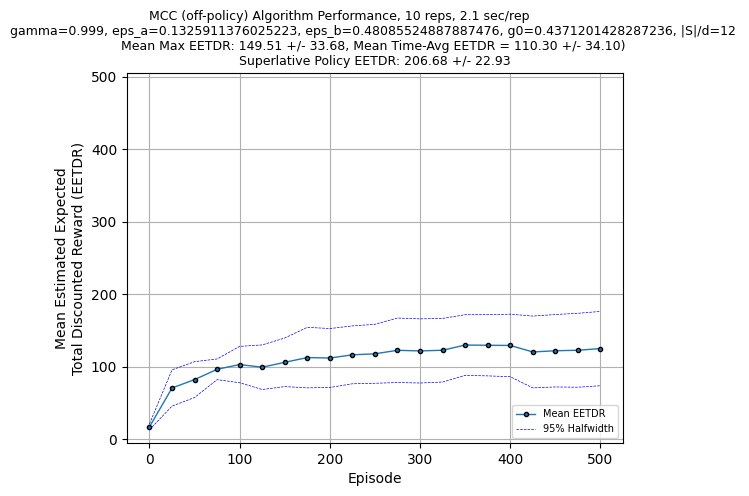

2.375430365365319


In [23]:
super_index = np.argmax(results_table[1:,6]) - np.argmax(results_table[1:,7]) # 95CILB calculated
superlative_off_policy = MCC(*np.array(results_table[super_index,1:4],float))
superlative_off_policy.train_off_policy(num_episodes=int(0.5e3),replications=10)
superlative_off_policy.show_results(on_or_off='off')
print(np.array(results_table[1:,-2],float).mean())

From this we can see how the policy behaves and how long it takes to execute. The superlative executes in about the same time as average. There appears to be a lower variance in performance as well.

# Comparison

Between the two algorithms the on-policy produces better results for this particular problem. Something that I found ot be interesting was that the confidence interval produced when using the off-policy algorithm was much smaller. Less suprisingly, iterations of the off-policy occured much faster. One can imagine that there are classes of problems where both of these will be much more advantageous. In particular, I would think that problems with significantly larger and more complex action- and/or state-spaces would benefit greatly from this. In that domain, the off-policy would likely have the additional advantage associated with exploration.

Why the on-policy algorithm appears to produce consistently better results is because the simplicity of this example environment, especially when discretized, and considering a $2$ action-space. Because of this simplicity, the propensity for exploitation makes the on-policy a clear superior performer.

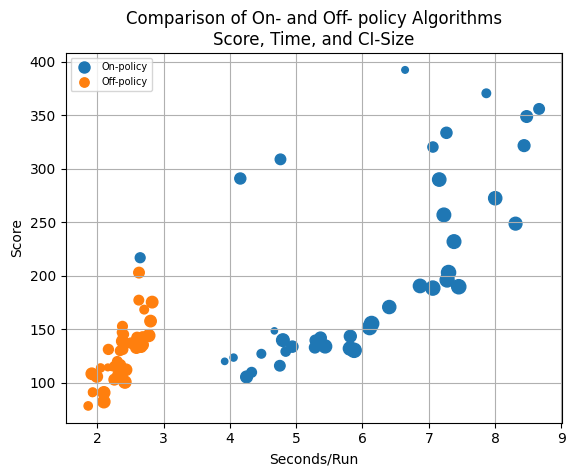

In [47]:
on_pol_df = pd.read_csv("MCC_onpolicy_results_DOE_20240510_025017.csv")
off_pol_df = pd.read_csv("MCC_offpolicy_results_DOE_20240510_031036.csv")

y1 = on_pol_df['Score']
x1 = on_pol_df['Secs per run']
s1 = on_pol_df['Mean Max EETDR hw']
y2 = off_pol_df['Score']
x2 = off_pol_df['Secs per run']
s2 = off_pol_df['Mean Max EETDR hw']

plt.scatter(x=x1, y=y1, s=s1, label="On-policy")
plt.scatter(x=x2, y=y2, s=s2, label="Off-policy")
plt.title(f"Comparison of On- and Off- policy Algorithms\nScore, Time, and CI-Size")
plt.ylabel("Score")
plt.xlabel("Seconds/Run")
# grid on
plt.grid()
# legend on
plt.legend(loc='upper left', fontsize=7)
#plt.figlegend(markerscale=True)    #legend_elements("sizes", num=3)
# display the plot
plt.show()

In producing this graphic, it becomes necessary to retract the previous assertion that there would be a noticable difference in the confidence interval size. There does not appear to be a significant difference. However, a different pattern of behavior that has not yet been discussed becomes clear. We can see here that off-policy does indeed perform faster, and the final performance of the off-policy produces scores essentially equivalent to the lesser half of on-policy experiements in less than half-the time.